In [ ]:
!pip -q install recbole==2.0.0 sentence-transformers==2.6.1 faiss-gpu ujson tqdm wandb
!pip install numpy pandas scipy implicit sentence-transformers torch tqdm scikit-learn

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import json, os, random
from pathlib import Path

import numpy as np
import pandas as pd
import scipy.sparse as sp
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

###############################################################################
# Yelp FULL‑SCALE all‑ranking experiment
# – loads the entire Yelp dataset (~6.8 M reviews, ~185 k businesses)
# – keeps all interactions (implicit)
# – evaluates Top‑K on the full unseen‑item set
###############################################################################

###############################################################################
# 0. Colab / Google Drive helpers
###############################################################################




BASE_DIR = Path("/content/drive/MyDrive/yelp")  # <-- change if needed


# ensure the folder exists
BASE_DIR.mkdir(parents=True, exist_ok=True)

REV_ZIP = BASE_DIR / "yelp_academic_dataset_review.json.zip"
REV_PATH = BASE_DIR / "yelp_academic_dataset_review.json"
BIZ_PATH = BASE_DIR / "yelp_academic_dataset_business.json"

# un‑zip reviews if only .zip is available
if not REV_PATH.exists() and REV_ZIP.exists():
    import zipfile, time

    print("Found zipped reviews file — extracting …")
    t0 = time.time()
    with zipfile.ZipFile(REV_ZIP, "r") as zf:
        zf.extractall(BASE_DIR)
    print(f"Unzipped to {REV_PATH} (took {time.time() - t0:.1f}s)")

###############################################################################
# 1. misc setup
###############################################################################

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# REV_PATH = "/Users/icereal/Desktop/vsc_projects/n-shot/yelp/yelp_academic_dataset_review.json"
# BIZ_PATH = "/Users/icereal/Desktop/vsc_projects/n-shot/yelp/yelp_academic_dataset_business.json"

In [5]:


def stream_json(path, limit=None):
    with open(path, encoding="utf-8") as f:
        for i, line in enumerate(f):
            if limit and i >= limit:
                break
            yield json.loads(line)

def topk_idx(a: np.ndarray, k: int):
    if a.size <= k:
        return np.argsort(-a)
    idx = np.argpartition(-a, k)[:k]
    return idx[np.argsort(-a[idx])]

###############################################################################
# 2. load Yelp
###############################################################################

reviews = pd.DataFrame(stream_json(REV_PATH))
biz     = pd.DataFrame(stream_json(BIZ_PATH))

###############################################################################
# 3. preprocessing
###############################################################################

reviews = reviews[["user_id", "business_id", "text", "date"]].assign(
    date=lambda d: pd.to_datetime(d.date)
)
biz = biz[["business_id", "name", "categories"]]

###############################################################################
# 4. map IDs → indices
###############################################################################

uid2i = {u: i for i, u in enumerate(reviews.user_id.unique())}
iid2i = {b: i for i, b in enumerate(biz.business_id.unique())}

reviews["u_idx"] = reviews.user_id.map(uid2i)
reviews["i_idx"] = reviews.business_id.map(iid2i)
biz["i_idx"] = biz.business_id.map(iid2i)

num_u, num_i = len(uid2i), len(iid2i)

###############################################################################
# 5. chrono split 80/20
###############################################################################

reviews = reviews.sort_values("date")
cut = int(len(reviews) * 0.8)
train, test = reviews.iloc[:cut], reviews.iloc[cut:]

cold_items = set(test.i_idx) - set(train.i_idx)
cold_users = set(test.u_idx) - set(train.u_idx)

###############################################################################
# 6. interaction matrix
###############################################################################

train_mat = sp.coo_matrix((np.ones(len(train)), (train.u_idx, train.i_idx)), shape=(num_u, num_i)).tocsr()

###############################################################################
# 7. CF models
###############################################################################

als = AlternatingLeastSquares(factors=64, random_state=RANDOM_SEED)
als.fit(train_mat)
als.user_factors[list(cold_users)] = 0.0
als.item_factors[list(cold_items)] = 0.0

bpr = BayesianPersonalizedRanking(factors=64, random_state=RANDOM_SEED, learning_rate=0.05)
bpr.fit(train_mat, show_progress=False)
bpr.user_factors[list(cold_users)] = 0.0
bpr.item_factors[list(cold_items)] = 0.0

###############################################################################
# 8. SBERT embeddings
###############################################################################

sbert = SentenceTransformer("BAAI/bge-base-en-v1.5")
item_text = (biz.name.fillna("") + " " + biz.categories.fillna("")).tolist()
item_emb = sbert.encode(item_text, batch_size=512, show_progress_bar=True, normalize_embeddings=True)

user_emb = np.zeros((num_u, item_emb.shape[1]), dtype=np.float32)
for u in tqdm(range(num_u), desc="user avg"):
    idx = train_mat[u].indices
    if len(idx):
        user_emb[u] = item_emb[idx].mean(axis=0)

cold_rows = test[test.u_idx.isin(cold_users)].groupby("u_idx").head(1)
user_emb[list(cold_rows.u_idx)] = sbert.encode(cold_rows.text.tolist(), normalize_embeddings=True)

###############################################################################
# 9. popularity
###############################################################################

item_pop = np.asarray(train_mat.sum(axis=0)).ravel()

###############################################################################
# 10. evaluation (true + 1000 neg)
###############################################################################

MODELS = ["ALS", "BPR", "POP", "LLM", "RAND"]
K = 10
N_NEG = 1000
rng = np.random.default_rng(RANDOM_SEED)

def evaluate(df: pd.DataFrame):
    hit, ndcg = {m: [] for m in MODELS}, {m: [] for m in MODELS}
    seen_cache = {}

    for _, row in tqdm(df.iterrows(), total=len(df), desc="eval"):
        u, true_i = int(row.u_idx), int(row.i_idx)
        if u not in seen_cache:
            seen_cache[u] = set(train_mat[u].indices)
        seen = seen_cache[u]
        if true_i in seen:
            continue

        pool = np.setdiff1d(np.arange(num_i, dtype=np.int32), list(seen), assume_unique=True)
        neg = rng.choice(pool, size=min(N_NEG, len(pool)), replace=False)
        cand = np.concatenate([[true_i], neg])  # cand[0] is true

        s_dict = {
            "ALS": als.user_factors[u] @ als.item_factors[cand].T,
            "BPR": bpr.user_factors[u] @ bpr.item_factors[cand].T,
            "POP": item_pop[cand],
            "LLM": user_emb[u] @ item_emb[cand].T,
            "RAND": rng.random(len(cand)),
        }

        for m, s in s_dict.items():
            top = topk_idx(s, K)
            hit_m = int(0 in top)
            dcg_m = 1 / np.log2(top.tolist().index(0) + 2) if hit_m else 0.0
            hit[m].append(hit_m)
            ndcg[m].append(dcg_m)

    return {m: {"Recall@10": np.mean(hit[m]), "NDCG@10": np.mean(ndcg[m])} for m in MODELS}

###############################################################################
# 11. run & print
###############################################################################

overall   = evaluate(test)
item_cold = evaluate(test[test.i_idx.isin(cold_items)])
user_cold = evaluate(test[test.u_idx.isin(cold_users)])



/usr/local/lib/python3.11/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/294 [00:00<?, ?it/s]

eval: 100%|██████████| 641528/641528 [25:18<00:00, 422.44it/s]


In [6]:
for tag, res in (("OVERALL", overall), ("ITEM-COLD", item_cold), ("USER-COLD", user_cold)):
    print(f"\n=== {tag} ===")
    for m in MODELS:
        print(f"{m:<3}  R@10 {res[m]['Recall@10']:.4f} | NDCG {res[m]['NDCG@10']:.4f}")


=== OVERALL ===
ALS  R@10 0.1824 | NDCG 0.1059
BPR  R@10 0.1188 | NDCG 0.0615
POP  R@10 0.1376 | NDCG 0.0764
LLM  R@10 0.1712 | NDCG 0.1199
RAND  R@10 0.0100 | NDCG 0.0045

=== ITEM-COLD ===
ALS  R@10 0.0000 | NDCG 0.0000
BPR  R@10 0.0000 | NDCG 0.0000
POP  R@10 0.0000 | NDCG 0.0000
LLM  R@10 0.1529 | NDCG 0.1063
RAND  R@10 0.0099 | NDCG 0.0045

=== USER-COLD ===
ALS  R@10 0.0000 | NDCG 0.0000
BPR  R@10 0.0000 | NDCG 0.0000
POP  R@10 0.1612 | NDCG 0.0924
LLM  R@10 0.3181 | NDCG 0.2320
RAND  R@10 0.0101 | NDCG 0.0046


In [8]:
overall

{'ALS': {'Recall@10': np.float64(0.18243280290142622),
  'NDCG@10': np.float64(0.10591918833545809)},
 'BPR': {'Recall@10': np.float64(0.11880217475376112),
  'NDCG@10': np.float64(0.06147601682869515)},
 'POP': {'Recall@10': np.float64(0.1375699166373634),
  'NDCG@10': np.float64(0.07643835067505542)},
 'LLM': {'Recall@10': np.float64(0.17123883033513929),
  'NDCG@10': np.float64(0.11989012346662953)},
 'RAND': {'Recall@10': np.float64(0.01004182387477255),
  'NDCG@10': np.float64(0.004543082825845117)}}

In [9]:
item_cold

{'ALS': {'Recall@10': np.float64(0.0), 'NDCG@10': np.float64(0.0)},
 'BPR': {'Recall@10': np.float64(0.0), 'NDCG@10': np.float64(0.0)},
 'POP': {'Recall@10': np.float64(0.0), 'NDCG@10': np.float64(0.0)},
 'LLM': {'Recall@10': np.float64(0.15288898934817619),
  'NDCG@10': np.float64(0.1063125879731378)},
 'RAND': {'Recall@10': np.float64(0.009945469443110219),
  'NDCG@10': np.float64(0.004501290180645866)}}

In [10]:
user_cold

{'ALS': {'Recall@10': np.float64(0.0), 'NDCG@10': np.float64(0.0)},
 'BPR': {'Recall@10': np.float64(0.0), 'NDCG@10': np.float64(0.0)},
 'POP': {'Recall@10': np.float64(0.16120886383758776),
  'NDCG@10': np.float64(0.09241312371113487)},
 'LLM': {'Recall@10': np.float64(0.31812952825130003),
  'NDCG@10': np.float64(0.231978460488164)},
 'RAND': {'Recall@10': np.float64(0.010125824593782345),
  'NDCG@10': np.float64(0.004567469966771414)}}

------ Recall@10 ------


Сплит,ITEM-COLD,OVERALL,USER-COLD
Модель,,,
ALS,0.0000,0.1824,0.0000
BPR,0.0000,0.1188,0.0000
POP,0.0000,0.1376,0.1612
LLM,0.1529,0.1712,0.3181
RAND,0.0099,0.0100,0.0101


------  NDCG@10  ------


Сплит,ITEM-COLD,OVERALL,USER-COLD
Модель,,,
ALS,0.0000,0.1059,0.0000
BPR,0.0000,0.0615,0.0000
POP,0.0000,0.0764,0.0924
LLM,0.1063,0.1199,0.2320
RAND,0.0045,0.0045,0.0046


<ipython-input-17-90793b957b5f>:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = mpl.cm.get_cmap('tab10')


\nLaTeX table (Recall):\n \begin{tabular}{lrrr}
\toprule
Сплит & ITEM-COLD & OVERALL & USER-COLD \\
Модель &  &  &  \\
\midrule
ALS & 0.0000 & 0.1824 & 0.0000 \\
BPR & 0.0000 & 0.1188 & 0.0000 \\
POP & 0.0000 & 0.1376 & 0.1612 \\
LLM & 0.1529 & 0.1712 & 0.3181 \\
RAND & 0.0099 & 0.0100 & 0.0101 \\
\bottomrule
\end{tabular}

\nLaTeX table (NDCG):\n \begin{tabular}{lrrr}
\toprule
Сплит & ITEM-COLD & OVERALL & USER-COLD \\
Модель &  &  &  \\
\midrule
ALS & 0.0000 & 0.1059 & 0.0000 \\
BPR & 0.0000 & 0.0615 & 0.0000 \\
POP & 0.0000 & 0.0764 & 0.0924 \\
LLM & 0.1063 & 0.1199 & 0.2320 \\
RAND & 0.0045 & 0.0045 & 0.0046 \\
\bottomrule
\end{tabular}



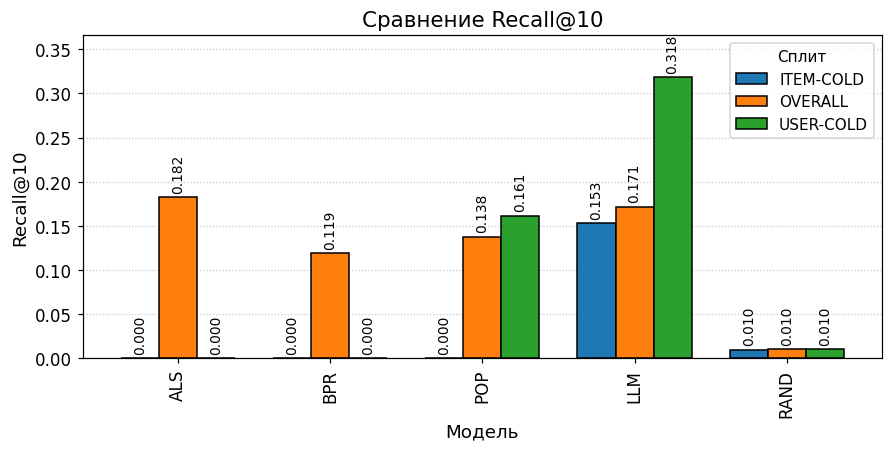

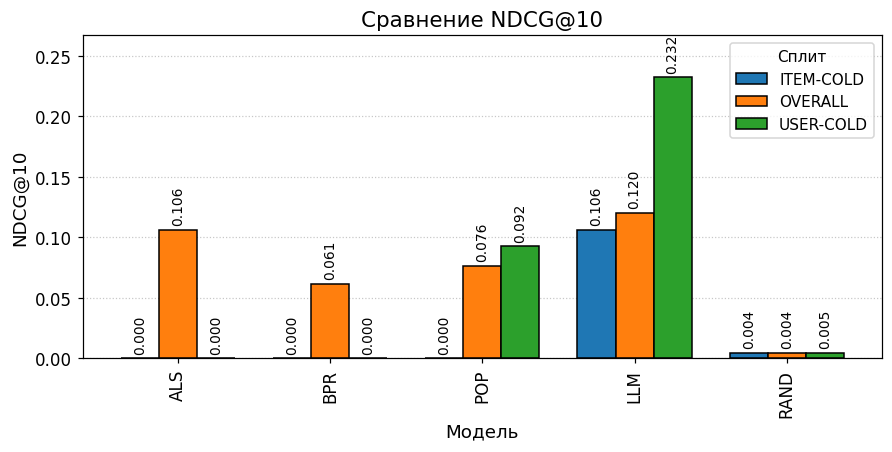

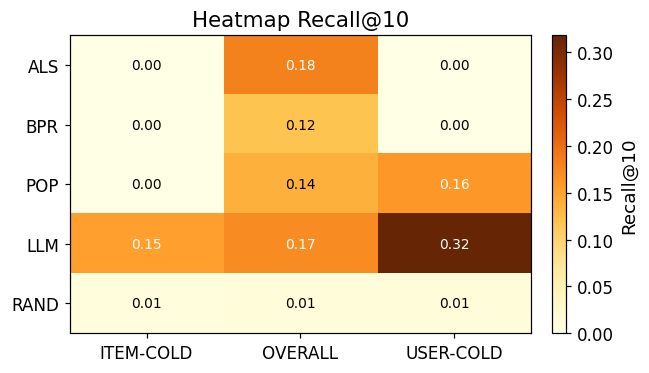

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
overall = { 
    'ALS':  {'Recall@10': 0.1824, 'NDCG@10': 0.1059},
    'BPR':  {'Recall@10': 0.1188, 'NDCG@10': 0.0615},
    'POP':  {'Recall@10': 0.1376, 'NDCG@10': 0.0764},
    'LLM':  {'Recall@10': 0.1712, 'NDCG@10': 0.1199},
    'RAND': {'Recall@10': 0.0100, 'NDCG@10': 0.0045},
}
item_cold = {
    'ALS':  {'Recall@10': 0.0000, 'NDCG@10': 0.0000},
    'BPR':  {'Recall@10': 0.0000, 'NDCG@10': 0.0000},
    'POP':  {'Recall@10': 0.0000, 'NDCG@10': 0.0000},
    'LLM':  {'Recall@10': 0.1529, 'NDCG@10': 0.1063},
    'RAND': {'Recall@10': 0.0099, 'NDCG@10': 0.0045},
}
user_cold = {
    'ALS':  {'Recall@10': 0.0000, 'NDCG@10': 0.0000},
    'BPR':  {'Recall@10': 0.0000, 'NDCG@10': 0.0000},
    'POP':  {'Recall@10': 0.1612, 'NDCG@10': 0.0924},
    'LLM':  {'Recall@10': 0.3181, 'NDCG@10': 0.2320},
    'RAND': {'Recall@10': 0.0101, 'NDCG@10': 0.0046},
}
############################################################################
# 1. Сбор в единый DataFrame
############################################################################
records = []
for split, blob in [('OVERALL', overall),
                    ('ITEM-COLD', item_cold),
                    ('USER-COLD', user_cold)]:
    for model, m in blob.items():
        records.append({'Сплит': split, 'Модель': model,
                        'Recall@10': float(m['Recall@10']),
                        'NDCG@10':   float(m['NDCG@10'])})
df = pd.DataFrame.from_records(records)

############################################################################
# 2. Сводные таблицы (pivot)
############################################################################
pivot_recall = (df.pivot(index='Модель', columns='Сплит',
                         values='Recall@10')
                  .reindex(df['Модель'].unique()))
pivot_ndcg   = (df.pivot(index='Модель', columns='Сплит',
                         values='NDCG@10')
                  .reindex(df['Модель'].unique()))

print('------ Recall@10 ------');  display(pivot_recall.round(4))
print('------  NDCG@10  ------');  display(pivot_ndcg.round(4))

# (если нужен LaTeX-код для вставки в ВКР)
print('\\nLaTeX table (Recall):\\n',
      pivot_recall.to_latex(float_format='%.4f'))
print('\\nLaTeX table (NDCG):\\n',
      pivot_ndcg.to_latex(float_format='%.4f'))

############################################################################
# 3. Настройки «научного» стиля графиков
############################################################################
mpl.rcParams.update({
    'font.family' : 'serif',
    'font.serif'  : 'Times New Roman',
    'axes.titlesize' : 14,
    'axes.labelsize' : 12,
    'legend.fontsize': 10,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
})

palette = mpl.cm.get_cmap('tab10')

############################################################################
# 4. Столбчатые диаграммы
############################################################################
def barplot(pivot, title, ylabel):
    fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
    bars = pivot.plot(kind='bar', width=0.75, color=palette.colors,
                      ax=ax, edgecolor='black')

    ax.set_xlabel('Модель')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(axis='y', linestyle=':', alpha=0.7)
    ax.set_axisbelow(True)
    ax.legend(title='Сплит', loc='upper right')

    # Подписи значений на столбиках
    for container in bars.containers:
        for bar in container:
            height = bar.get_height()
            if np.isnan(height): continue
            bars.annotate(f'{height:.3f}',
                          xy=(bar.get_x() + bar.get_width() / 2, height),
                          xytext=(0, 3), textcoords='offset points',
                          ha='center', va='bottom', fontsize=9, rotation=90)

    # Увеличим лимит по Y, чтобы подписи не выходили за границы
    y_max = max([p.get_height() for p in ax.patches if not np.isnan(p.get_height())])
    ax.set_ylim(0, y_max * 1.15)

    plt.show()



barplot(pivot_recall, 'Сравнение Recall@10', 'Recall@10')
barplot(pivot_ndcg,   'Сравнение NDCG@10',   'NDCG@10')

############################################################################
# 5. Тепловая карта (Heatmap) — быстро видно “кто лучше где”
############################################################################
fig, ax = plt.subplots(figsize=(6,3.5))
img = ax.imshow(pivot_recall.values, cmap='YlOrBr', aspect='auto')

ax.set_xticks(range(len(pivot_recall.columns)), pivot_recall.columns)
ax.set_yticks(range(len(pivot_recall.index)),   pivot_recall.index)
ax.set_title('Heatmap Recall@10')
for i in range(len(pivot_recall.index)):
    for j in range(len(pivot_recall.columns)):
        val = pivot_recall.iloc[i,j]
        ax.text(j, i, f'{val:.2f}', ha='center', va='center',
                color='black' if val<0.15 else 'white', fontsize=9)

fig.colorbar(img, ax=ax, fraction=0.046, pad=0.04, label='Recall@10')
plt.tight_layout()
plt.show()